In [45]:
from dataclasses import dataclass

import casadi as ca
import geometry as geo
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

from utils import get_position, Position, my_odometry

In [46]:
plt.rcParams['figure.figsize'] = [7, 7]

In [47]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [48]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
    frame_rate=10
)

In [49]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [50]:
env.reset()
for _ in range(100):
    obs, reward, done, info = env.step([1,1])
    if done:
        break
    print(info["Simulator"]["robot_speed"])

0.30000000000000027
0.4500000000000004
0.5249999999999999
0.5625000000000002
0.5812499999999998
0.5906250000000002
0.5953125000000004
0.5976562500000004
0.5988281249999994
0.5994140625000011
0.5997070312500008
0.5998535156249996
0.5999267578125012
0.5999633789062497
0.599981689453124
0.5999908447265634
0.599995422363282


In [51]:
delta_time = 1.0 / env.frame_rate

https://drive.google.com/file/d/19U1DUo3GtqHxncEKLn2d6RRdLTLgD0Bv/view

In [60]:
def my_odom(dt=0.033):
    """
    Return the model casadi function tuned according to the parameter found in the thesis.

    :param dt: the time step
    """
    u1 = 7.662 # 5
    u2 = 0.325
    u3 = -0.050
    w1 = 6.826 # 4
    w2 = -4.929
    w3 = -6.515
    # parameters for forced dynamics
    # u_alpha_r = 1.5
    # u_alpha_l = 1.5
    # w_alpha_r = 15  # modify this for trim
    # w_alpha_l = 15
   
    u_alpha_r = 2.755
    u_alpha_l = 2.741
    w_alpha_r = 14.663  # modify this for trim
    w_alpha_l = 14.662
    # States
    x0 = ca.MX.sym('x')
    y0 = ca.MX.sym('y')
    th0 = ca.MX.sym('th')
    w0 = ca.MX.sym('w')
    v0 = ca.MX.sym('v')
    x = ca.vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
    # Inputs
    wl = ca.MX.sym('wl')
    wr = ca.MX.sym('wr')
    u = ca.vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
    
    # V =  [[wl], [wr]]
    V = ca.vertcat(wl, wr)

    f_dynamic = ca.vertcat(-u1 * v0 - u2 * w0 + u3 * w0 ** 2, -w1 * w0 - w2 * v0 - w3 * v0 * w0)
    # input Matrix
    B = ca.DM([[u_alpha_r, u_alpha_l], [w_alpha_r, -w_alpha_l]])
    # forced response
    f_forced = B@V
    # acceleration
    X_dot_dot = f_dynamic + f_forced
    
    v1 = v0 + X_dot_dot[0] * dt
    w1 = w0 + X_dot_dot[1] * dt
    x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
    # Cannot use atan2 because x1 and y1 are approximated while th1 is not
    theta1 = th0 + w0*dt
    dae = ca.vertcat(x1, y1, theta1, v1, w1)
    F = ca.Function('F',[x,u],[dae],['x','u'],['dae'])
    return F

In [61]:
F = my_odom(dt=0.01)

(2, 1)


In [62]:
pose = get_position(env)

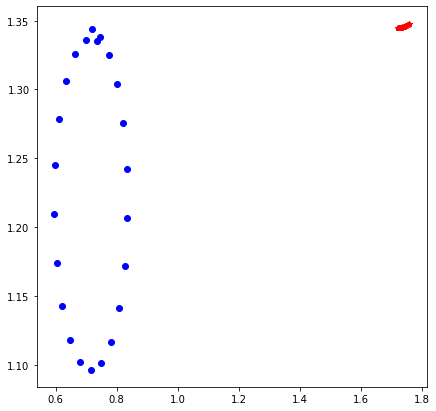

In [65]:
N_test=20
N = 10
T = 15
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [ ]:
pd.DataFrame(odoms)

,x,y,theta
0,0.702000,1.344706,0.000000
1,0.702000,1.344706,0.000000
2,0.702000,1.344706,0.000000
3,0.702000,1.344706,0.000000
4,0.702000,1.344706,0.000000
5,0.704000,1.344693,-0.013333
6,0.707665,1.344599,-0.038222
7,0.712713,1.344317,-0.073126
8,0.718898,1.343728,-0.116709
9,0.726003,1.342711,-0.167815


In [ ]:
pd.DataFrame(poses)

,x,y,theta
0,0.702000,1.344706,0.0
1,0.702000,1.344706,0.0
2,0.702000,1.344706,0.0
3,0.702000,1.344706,0.0
4,0.704000,1.344693,-0.8
5,0.707665,1.344599,-2.2
6,0.712713,1.344317,-4.2
7,0.718897,1.343728,-6.7
8,0.726001,1.342711,-9.6
9,0.733828,1.341152,-12.9
